In [1]:
import pandas as pd
import pathlib
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
oddsratio_cutoff = 1.3
lgp_cutoff = 8

## Motif Info

In [3]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/ref/MEME/selected_motifs_sets/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.csv', 
    index_col=0
)

## TE

In [4]:
for te_study in ['DNA', 'LINE', 'SINE', 'LTR']:
    output_dir = f'./TE/TE-{te_study}/'
    output_path = f'./TE/TE-{te_study}.total_enrichment.msg'
    
    output_dir = pathlib.Path(output_dir)
    enrich_files = list(output_dir.glob('*motif_enrichment.msg'))
    total_result = pd.concat([pd.read_msgpack(p) for p in enrich_files])
    
    filtered_result = total_result[(total_result['oddsratio'] > oddsratio_cutoff) & 
                                   (total_result['-lgp'] > lgp_cutoff)]
    
    motif_gene_info = filtered_result.index.map(lambda i: motif_gene_anno.loc[i])
    motif_gene_info = pd.DataFrame(motif_gene_info.tolist())
    total_result = pd.concat([filtered_result, motif_gene_info], axis=1)
    
    total_result.to_msgpack(output_path)

In [5]:
output_dir = f'./TE/NO-TE/'
output_path = f'./TE/TE-NO.total_enrichment.msg'

output_dir = pathlib.Path(output_dir)
enrich_files = list(output_dir.glob('*motif_enrichment.msg'))
total_result = pd.concat([pd.read_msgpack(p) for p in enrich_files])

filtered_result = total_result[(total_result['oddsratio'] > oddsratio_cutoff) & 
                               (total_result['-lgp'] > lgp_cutoff)]

motif_gene_info = filtered_result.index.map(lambda i: motif_gene_anno.loc[i])
motif_gene_info = pd.DataFrame(motif_gene_info.tolist())
total_result = pd.concat([filtered_result, motif_gene_info], axis=1)

total_result.to_msgpack(output_path)

## Plot TE

In [4]:
subtype_order = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/order/SubType.order.txt',
                            index_col=0, header=None).index

In [5]:
te_dna = pd.read_msgpack('./TE/TE-DNA.total_enrichment.msg')
te_dna['StudyName'] = 'TE-DNA'

te_line = pd.read_msgpack('./TE/TE-LINE.total_enrichment.msg')
te_line['StudyName'] = 'TE-LINE'

te_sine = pd.read_msgpack('./TE/TE-SINE.total_enrichment.msg')
te_sine['StudyName'] = 'TE-SINE'

te_ltr = pd.read_msgpack('./TE/TE-LTR.total_enrichment.msg')
te_ltr['StudyName'] = 'TE-LTR'

te_no = pd.read_msgpack('./TE/TE-NO.total_enrichment.msg')
te_no['StudyName'] = 'TE-NO'

df_list = [te_dna, te_line, te_sine, te_ltr, te_no]
names = ['TE DNA', 'TE LINE', 'TE SINE', 'TE LTR', 'Not TE']

In [6]:
total_names = []
for df in df_list:
    total_names += df['motif_name'].tolist()
motif_order = sorted(set(total_names))
len(motif_order)

628

In [7]:
def plot_cluster_map(input_data, ax):
    data = input_data[input_data['DMRType'] == 'Hyper'].set_index(['SubType', 'motif_name'])['oddsratio'].unstack()
    data = data.reindex(subtype_order).T.reindex(motif_order).T.fillna(1)
    sns.heatmap(data, ax=ax, cbar=None, vmin=1, vmax=3)
    return

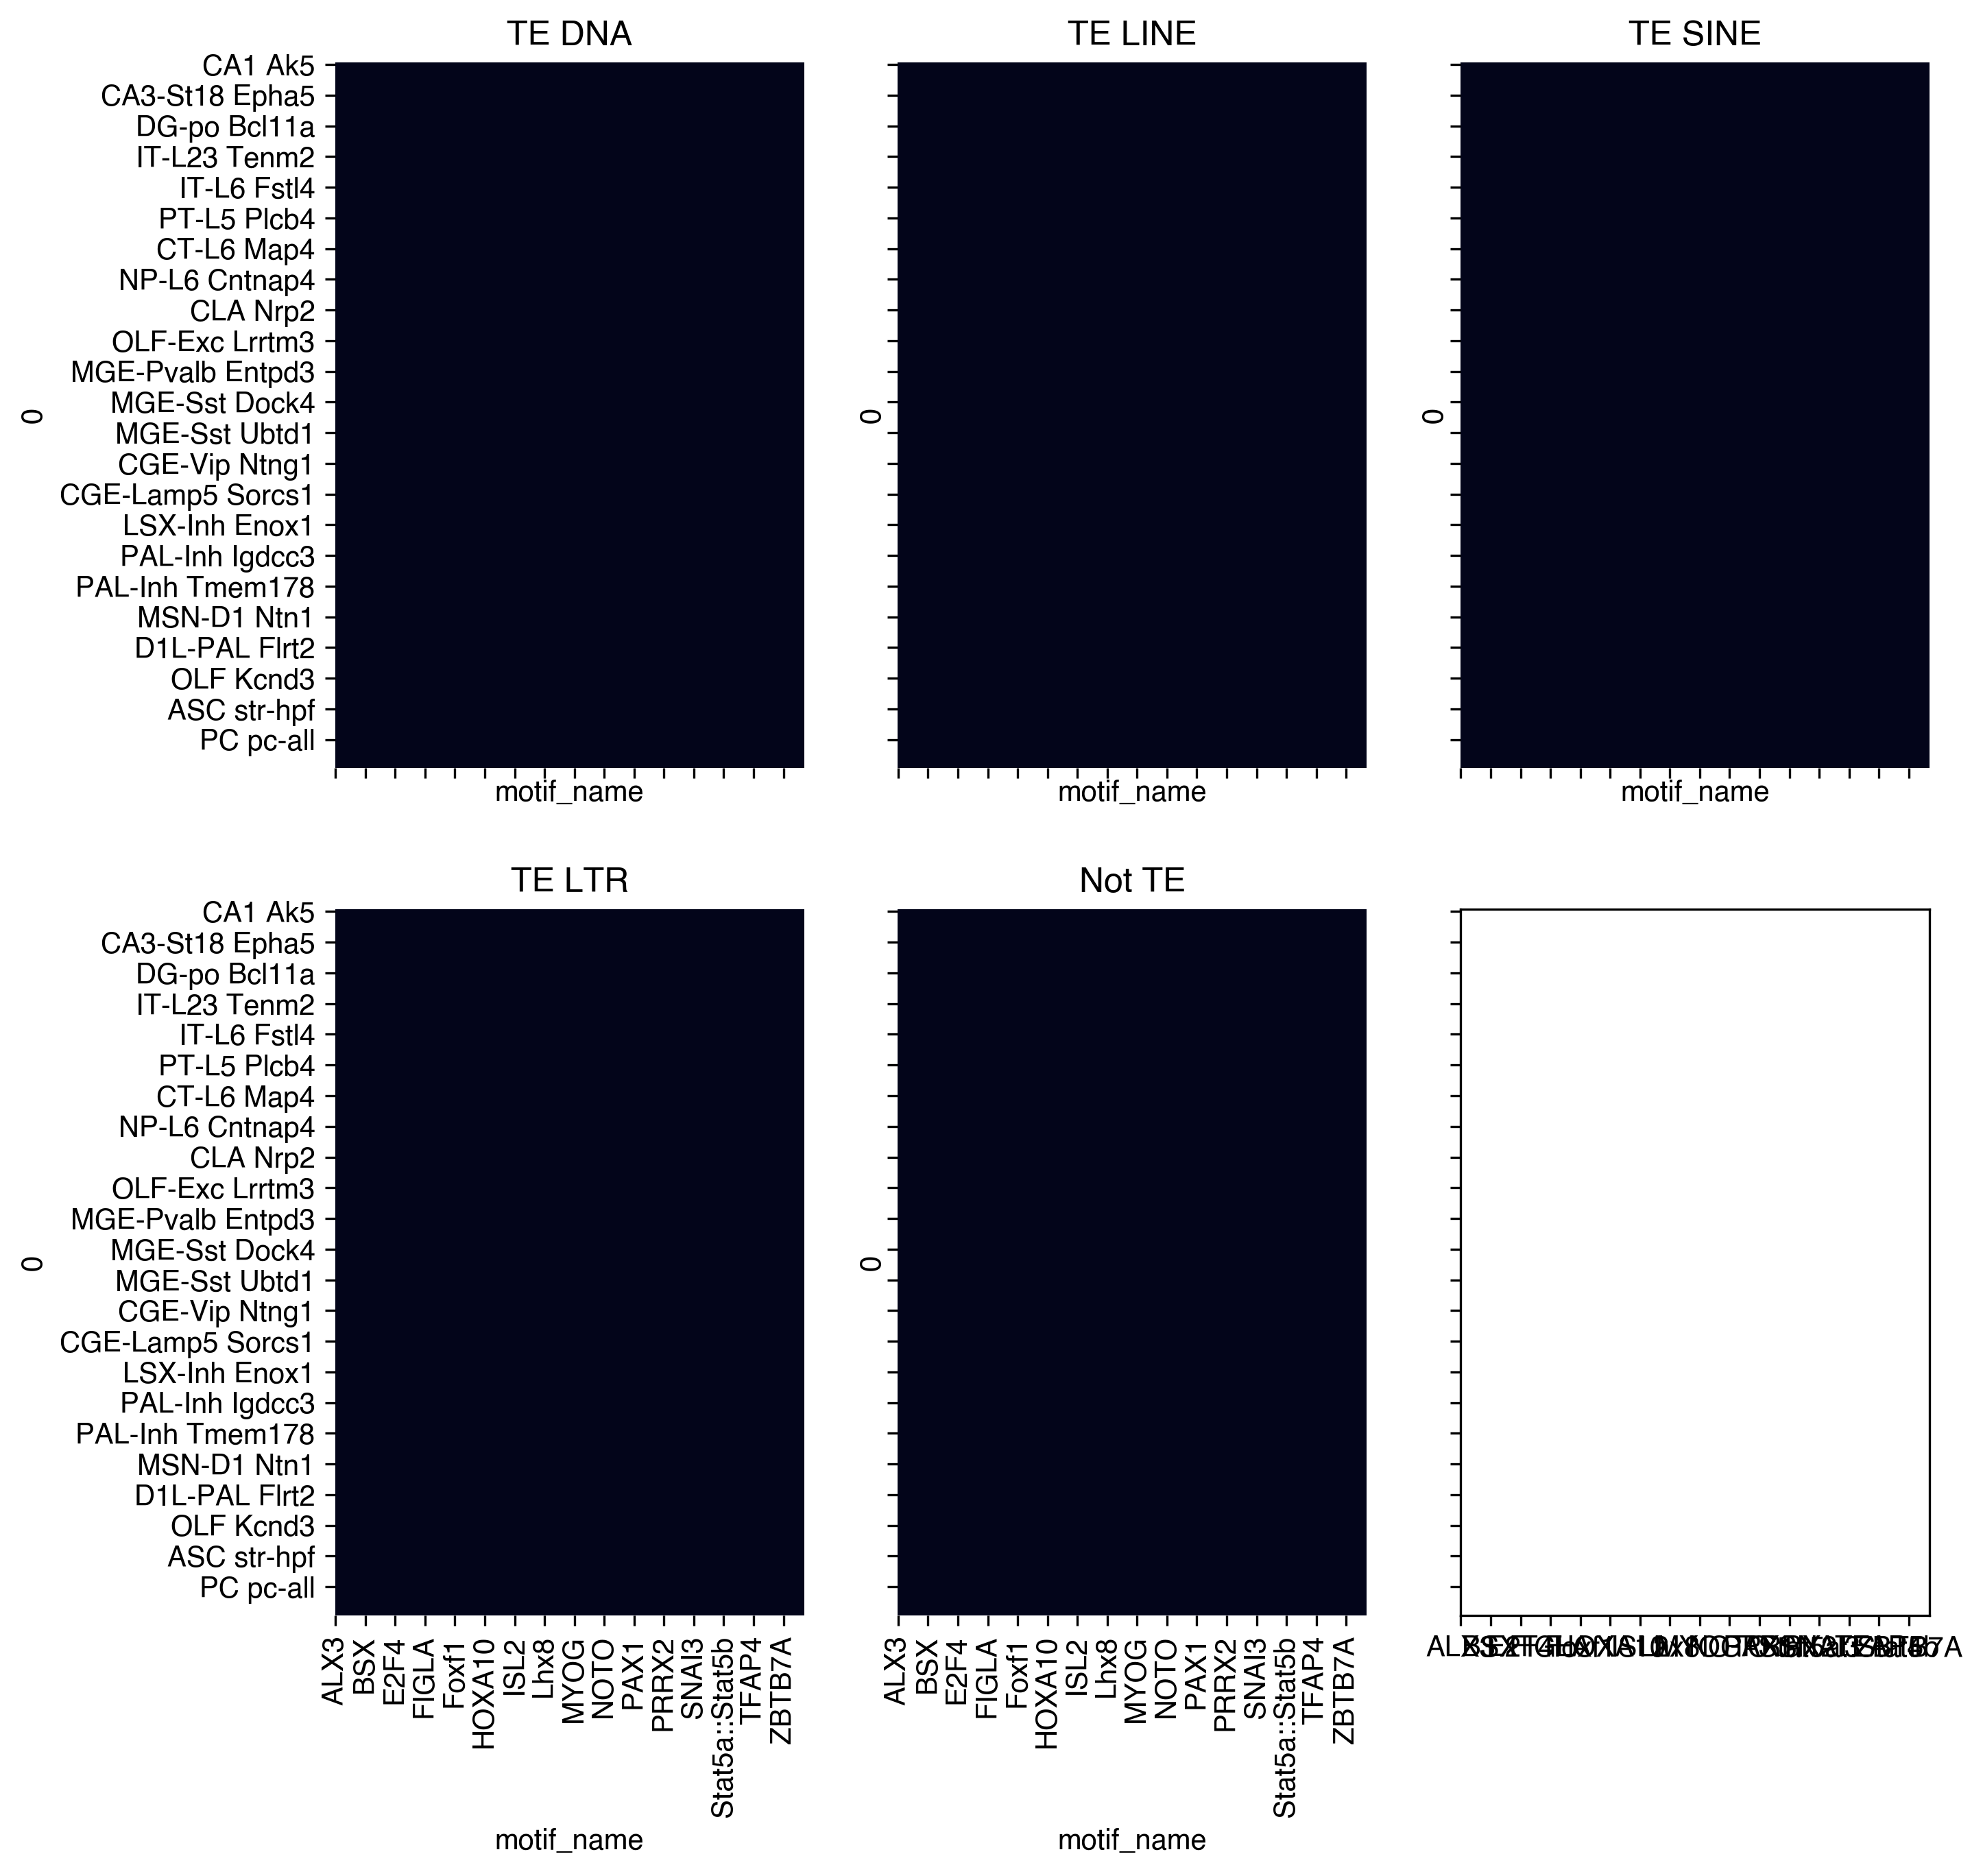

In [8]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=3, dpi=300, sharex=True, sharey=True)

for df, ax, name in zip(df_list, axes.flat, names):
    ax.set(title=name)
    plot_cluster_map(df, ax)

In [9]:
total_results = pd.concat(df_list)
total_results['motif_id'] = total_results.index

In [10]:
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv', index_col=0)
print(tf_class.columns)

def get_gene_tf_class_map(level):
    total_gene_map = {}
    for _, row in tf_class.iterrows():
        if isinstance(row['EnsemblID'], float):
            continue
        for gene in row['EnsemblID'].split(','):
            total_gene_map[gene] = row[level]
    return total_gene_map

gene_idbase_to_tf_family = get_gene_tf_class_map('Family')

Index(['GeneRawName', 'SuperClass', 'Class', 'Family', 'SubFamily',
       'EnsemblID'],
      dtype='object')


In [11]:
tf_class_terms = []
for genes in total_results['gene_ids']:
    terms = []
    for g in genes.split(','):
        g = g.split('.')[0]
        if g in gene_idbase_to_tf_family:
            terms.append(gene_idbase_to_tf_family[g])
    term = ','.join(terms)
    tf_class_terms.append(term)
    
total_results['TFClass'] = tf_class_terms

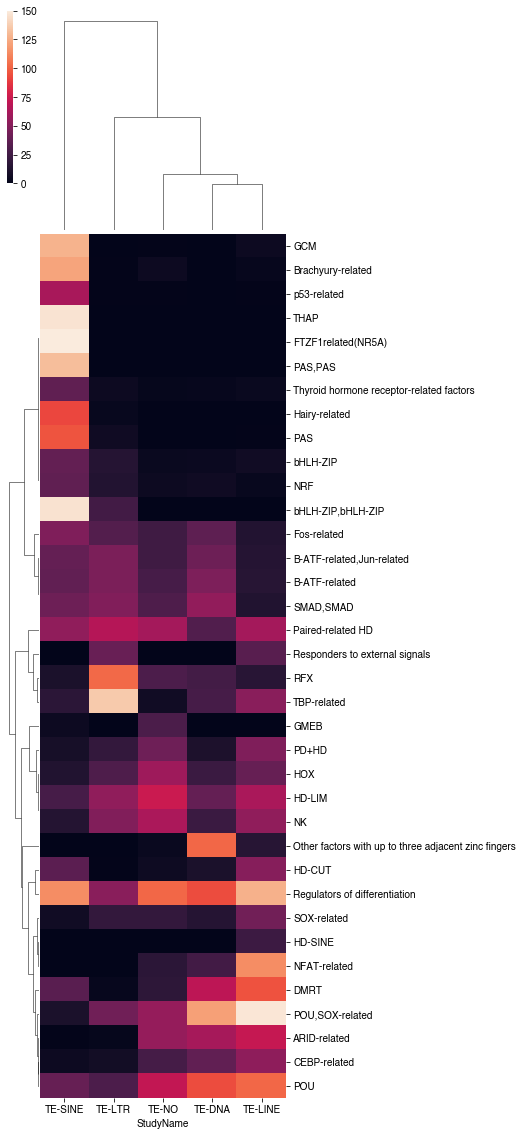

In [12]:
tf_hits = total_results[total_results['DMRType'] == 'Hypo'].groupby('motif_id')['StudyName'].value_counts().unstack().fillna(0)
tf_hits = tf_hits.groupby(pd.Series(total_results['TFClass'].to_dict())).mean()

sns.clustermap(tf_hits[tf_hits.std(axis=1) > 10], 
               metric='correlation', figsize=(5, 20))

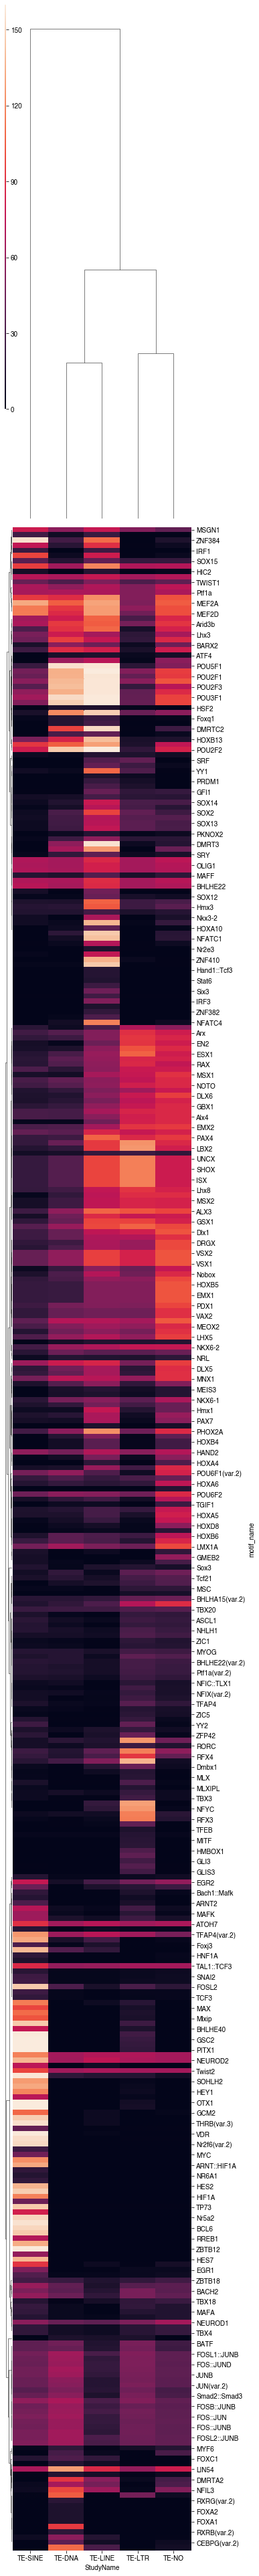

In [15]:
tf_hits = total_results[total_results['DMRType'] == 'Hypo'].groupby('motif_name')['StudyName'].value_counts().unstack().fillna(0)
sns.clustermap(tf_hits[tf_hits.std(axis=1) > 5], 
               metric='correlation', figsize=(5, 70))


In [22]:
total_results[total_results['gene_names'] == 'Ctcf']['DMRType'].value_counts()

Hyper    86
Hypo     20
Name: DMRType, dtype: int64